<a href="https://colab.research.google.com/github/BenGutteridge/VAD-Humbug/blob/master/webrtc_tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#WebRTC VAD Tester 
This notebook contains scripts to demonstrate the testing of the WebRTC Voice Activity Detector on a number of different test audio files. This notebook will automatcially load all files and dependencies in the blocks below, and parameters can be experimented with in the main script near the bottom.

The 8 test files provided here are:
- 3 CDC mosquito recordings
- A background recording from the Humbug project
- 2 longer mosquito files from the Humbug project, that are concatenations of several dozen shorter mosquito recordings, one from Tanzania (IHI) and one from the DRC.
- Two half hour recordings with Korean speech from the Kaist VAD dataset (bus_stop and construction_site).

### Installing libraries, dependencies, loading files (only run once)

In [1]:
%%capture
!pip install librosa
!pip install soundfile as sf
!pip install webrtcvad
!pip install pyloudnorm

In [2]:
!git clone https://github.com/BenGutteridge/VAD-Humbug.git

Cloning into 'VAD-Humbug'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 41 (delta 6), reused 11 (delta 4), pack-reused 23
Unpacking objects: 100% (41/41), done.
Checking out files: 100% (21/21), done.


In [3]:
import os
if not os.getcwd().endswith('VAD-Humbug'):
  os.chdir('VAD-Humbug')

In [5]:
import librosa
import soundfile as sf
import webrtcvad
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from VAD_pipeline import VAD_pipeline
from webrtc_vad import VAD
from webrtc_utils import plt_speech, speech_stats
import IPython.display as ipd

### Define function that performs tests (only run once)

In [6]:
def webrtc_tester(audiodir, labelspath, aggressiveness, norm_LU=False, plots_on=False):
    '''
    Parameters
    ----------
    audiodir : str
        Path to folder containing audio files to analyse.
    labelspath : str
        Path to folder containing speech label txt files with identical names to the .wav files.
    aggressiveness : int
        Aggressiveness with which noise is removed from file (0-3).
    norm_LU : int or False, optional
        Takes a value that must be a negative integer as the target LU at which to loudness normalise the file (dB). The default is False, i.e. no normalisation.
    plots_on : bool or int, optional
        Decides if/how many plots of true/predicted speech to plot for the files given. False: no plots (default); True: plot all files; integer n: plot the first n files
    chunks : bool, optional
        Produces audio chunks for detected speech. Not. The default is False.

    Returns
    -------
    true_speech: list of floats
        List with each element the number of seconds of correctly identified speech in each file.
    speech_total_length: list of floats
        List with each element the total number of seconds of speech in each file, given by the speech labels
    '''
    pltcount = 0
    true_speech, speech_total_length = [], []
    if plots_on==True: plots_on = np.inf     # plot all files if no limit set
    if norm_LU:
        normdir = join(audiodir,'norm')
        if not os.path.exists(normdir): os.mkdir(normdir)
        for file in os.listdir(audiodir):
            if file.endswith('.wav'):
                VAD_pipeline(audiodir, file, normdir, agg=aggressiveness, sr=8000, LU=norm_LU, norm_only=False) 
        audiodir = normdir

    for file in os.listdir(audiodir):
        if file.endswith('.wav'):
            audio, sr = librosa.load(join(audiodir,file), sr=2000)
            speech_pred_labels = VAD(join(audiodir,file), aggressiveness, chunks=False)
            filename = file.rstrip('.wav')
            try:
                speech_labels = np.loadtxt(join(labelspath,filename)+'.txt', usecols=(0,1))
            except:
                # If label file not found, print warning and process with no speech labels
                print('\nFile: %s\nLabel file not found, assuming no speech.\n' % file)
                speech_labels = np.array([[0,0]])
            file_length = audio.shape[0]/sr
            
            # reshape to 2D for files with only one pair of labels
            if speech_labels.shape == (2,): speech_labels = np.array([speech_labels])
            
            # Plot the true and predicted speech
            if pltcount < plots_on:
                plt_speech(speech_pred_labels, speech_labels, file_length, filename, audio, sr)
                pltcount += 1
            
            # Get and print test information
            print('\nFile:', file)
            stats = speech_stats(speech_pred_labels, speech_labels, file_length)
            # Keep running total of length of speech and length predicted correctly
            true_speech.append(stats[0])
            speech_total_length.append(stats[1])
    return(true_speech, speech_total_length)


###Run script

Choose a number of parameters:
- aggressiveness is the aggressiveness with which noise is removed. As we want to remove speech, and thus favour erroneous speech classification over erroneous noise classification, we use aggressiveness = 0. We can choose in {0, 1, 2, 3}
- plots_on determines whether we plot true/predicted speech:
  - True for plot all files
  - False for plot none
  - Or give an integer value $n$ and plot the first $n$ files.
- norm_LU determines loudness normalisation of the input files. Input can be either None, for no normalization, or a negative integer number, which represents loudness units, the average loudness of the file as a number of dB below the maximum range. -23 is the broadcasting standard, but we use -35 as it is similar to the loudness of our test files. 

Then produce a confusion matrix for each file, and plot the occurence of true and predicted speech labels, and the original audio.

In [11]:
aggressiveness = 0    # False positives preferred to false negatives
plots_on = True       # Plot true/predicted speech. False for none, True for all, or an int number
norm_LU = None       # None or a number

path = 'input'
labelspath = join(path, 'speech_labels') 


File: CDC_Ae-albopictus.wav
             True Speech  True Noise
 Pred Speech        9.98      973.21 | 983.19
  Pred Noise        0.00       12.69 |  12.69
             ---------------------------------
                    9.98      985.90 | 995.88
Predicted 99 percent of file as speech.
In reality 1 percent of file is speech.
100.00 percent of speech sounds *incidents* correctly classified (2 out of 2)
100.00 percent of speech sound in seconds correctly classified (9.98 seconds out of 9.98)

File: IHI_tascam_1-2_concatenated.wav
             True Speech  True Noise
 Pred Speech      257.23      145.94 | 403.17
  Pred Noise       11.94      275.10 | 287.03
             ---------------------------------
                  269.16      421.04 | 690.20
Predicted 58 percent of file as speech.
In reality 39 percent of file is speech.
100.00 percent of speech sounds *incidents* correctly classified (78 out of 78)
95.57 percent of speech sound in seconds correctly classified (257.23 seconds o

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


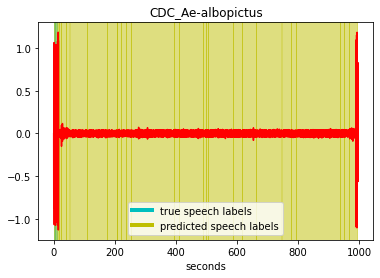

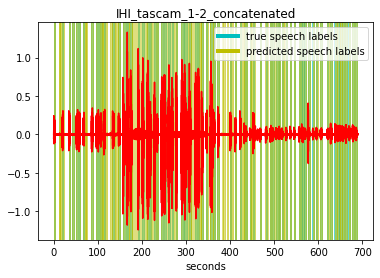

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


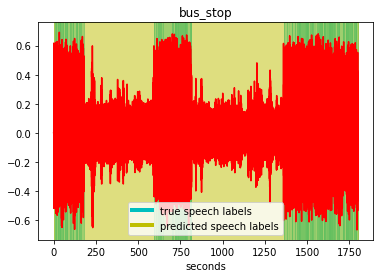

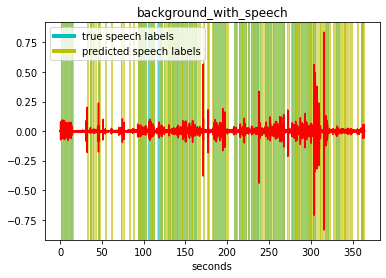

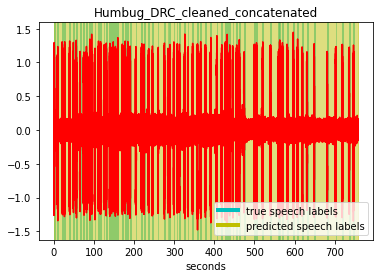

In [12]:
audiodir = path

true_speech, speech_total_length = webrtc_tester(audiodir=audiodir, 
                  labelspath=labelspath, 
                  aggressiveness=aggressiveness, 
                  norm_LU=norm_LU, 
                  plots_on=plots_on)

tpr_overall = np.sum(true_speech)/np.sum(speech_total_length)
print('\nOVERALL:\n%.4f percent of speech detected (%.2f out of %.2f seconds)' \
      % (100*tpr_overall, np.sum(true_speech), np.sum(speech_total_length)))

Note that using a normalisation of -35 drastically improves results for the DRC and Kaist recordings:


CDC_Ae-albopictus.wav
Length = 995.88s
Loudness = -32.24dB
New loudness = -35.00dB

IHI_tascam_1-2_concatenated.wav
Length = 690.20s
Loudness = -17.81dB
New loudness = -35.00dB

bus_stop.wav
Length = 1801.50s
Loudness = -21.79dB
New loudness = -35.00dB

construction_site.wav
Length = 1801.66s
Loudness = -23.86dB
New loudness = -35.00dB

CDC_Ae-aegypti.wav
Length = 1062.96s
Loudness = -35.05dB


/usr/local/lib/python3.6/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


New loudness = -35.00dB

CDC_Cx-quinquefasciatus.wav
Length = 1116.60s
Loudness = -34.49dB
New loudness = -35.00dB

background_with_speech.wav
Length = 364.21s
Loudness = -36.86dB


/usr/local/lib/python3.6/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


New loudness = -35.00dB

Humbug_DRC_cleaned_concatenated.wav
Length = 758.53s
Loudness = -7.90dB
New loudness = -35.00dB

File: CDC_Ae-albopictus.wav
             True Speech  True Noise
 Pred Speech        9.98      174.16 | 184.14
  Pred Noise        0.00      811.74 | 811.74
             ---------------------------------
                    9.98      985.90 | 995.88
Predicted 18 percent of file as speech.
In reality 1 percent of file is speech.
100.00 percent of speech sounds *incidents* correctly classified (2 out of 2)
100.00 percent of speech sound in seconds correctly classified (9.98 seconds out of 9.98)

File: IHI_tascam_1-2_concatenated.wav
             True Speech  True Noise
 Pred Speech      253.40       74.02 | 327.42
  Pred Noise       15.76      347.02 | 362.78
             ---------------------------------
                  269.16      421.04 | 690.20
Predicted 47 percent of file as speech.
In reality 39 percent of file is speech.
100.00 percent of speech sounds *incid

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


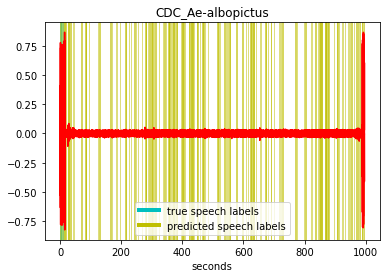

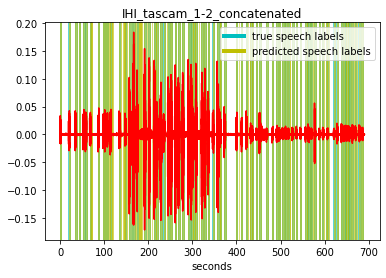

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


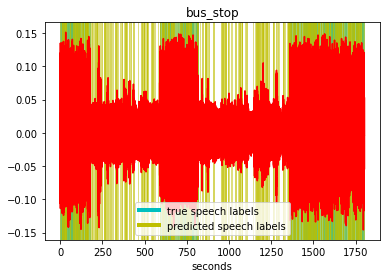

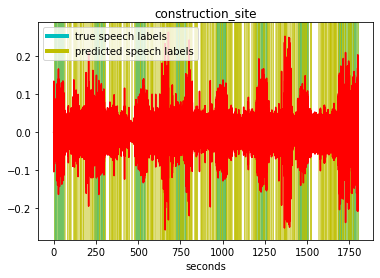

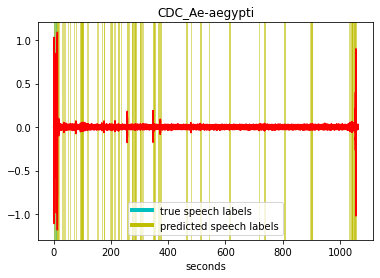

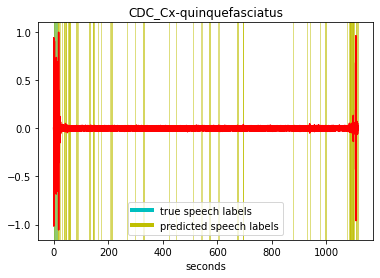

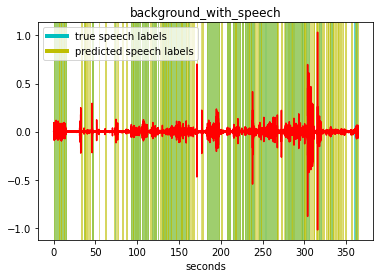

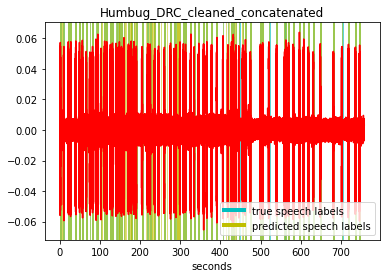

In [9]:
norm_LU = -35   # similar to loudness of CDC files, which perform well

true_speech, speech_total_length = webrtc_tester(audiodir=audiodir, 
                  labelspath=labelspath, 
                  aggressiveness=aggressiveness, 
                  norm_LU=norm_LU, 
                  plots_on=plots_on)

tpr_overall = np.sum(true_speech)/np.sum(speech_total_length)
print('\nOVERALL:\n%.4f percent of speech detected (%.2f out of %.2f seconds)' \
      % (100*tpr_overall, np.sum(true_speech), np.sum(speech_total_length)))

## Output files with speech removed
Here are a few examples of the above files, stripped of speech, for various loudnesses.

In [9]:
file_to_load = 'bus_stop.wav'
LU = None

if not os.path.exists('output'): os.mkdir('output')
VAD_pipeline('input', file_to_load, 'output', agg=0, sr=8000, LU=LU)
try:
  y,sr = librosa.load(join('output',file_to_load), sr=8000)
  ipd.display(ipd.Audio(y, rate=sr, autoplay=True))
except:
  pass


bus_stop.wav
Length = 1801.50s
Loudness = -21.79dB
File not processed, entirely speech detected


In [10]:
file_to_load = 'background_with_speech.wav'
LU = None

VAD_pipeline('input', file_to_load, 'output', agg=0, sr=8000, LU=LU)
try:
  y,sr = librosa.load(join('output',file_to_load), sr=8000)
  ipd.display(ipd.Audio(y, rate=sr, autoplay=True))
except:
  pass


background_with_speech.wav
Length = 364.21s
Loudness = -36.86dB
New length = 154.06s
Loudness unchanged
